# 04 - Ensemble Analysis: TF-IDF vs Legal-Longformer

**Objective**: Quantify model complementarity to assess ensemble potential.

Analysis:
- Load predictions from both models (test set only)
- Agreement/disagreement patterns
- Per-class strengths
- Ensemble strategies (union, intersection, weighted)
- Key findings for Question 3

In [1]:
import sys
sys.path.insert(0, '..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.metrics import f1_score, precision_score, recall_score

from src.data_loader import DataLoader
from src.model_trainer import DataPreparer
from src.model_evaluator import MultiLabelEvaluator

sns.set_style('whitegrid')
pd.set_option('display.max_colwidth', 50)

## 1. Load Ground Truth

In [2]:
# Load data to get ground truth labels
loader = DataLoader('../data/TRDataChallenge2023.txt')
preparer = DataPreparer(loader, min_label_count=50, random_state=42)
data = preparer.prepare(max_features=10000, ngram_range=(1, 2))

y_true = data.y_test
labels = data.label_names

print(f"Test set: {len(y_true)} samples, {len(labels)} classes")

Test set: 2509 samples, 41 classes


## 2. Load Model Predictions

In [ ]:
# Load TF-IDF predictions
tfidf_path = Path('../outputs/tfidf_test_predictions.npz')
if not tfidf_path.exists():
    raise FileNotFoundError(f"Run NB 02 first to generate {tfidf_path}")

tfidf_data = np.load(tfidf_path)
y_pred_tfidf = tfidf_data['y_pred']
y_proba_tfidf = tfidf_data['y_proba']

print(f"✓ Loaded TF-IDF predictions: {y_pred_tfidf.shape}")

✓ Loaded TF-IDF predictions: (2509, 41)


In [ ]:
# Load Legal-Longformer predictions
lf_path = Path('../outputs/legal_longformer_test_predictions.npz')
if not lf_path.exists():
    raise FileNotFoundError(f"Run NB 03 first to generate {lf_path}")

lf_data = np.load(lf_path)
y_pred_lf = lf_data['y_pred']
y_proba_lf = lf_data['y_proba']

print(f"✓ Loaded Legal-Longformer predictions: {y_pred_lf.shape}")

✓ Loaded Legal-Longformer predictions: (2509, 41)


In [ ]:
# Baseline performance
evaluator = MultiLabelEvaluator(labels)

results_tfidf = evaluator.evaluate(y_true, y_pred_tfidf)
results_lf = evaluator.evaluate(y_true, y_pred_lf)

print("Baseline Performance:")
print(f"  TF-IDF:           F1 Micro={results_tfidf.f1_micro:.4f}, F1 Macro={results_tfidf.f1_macro:.4f}")
print(f"  Legal-Longformer: F1 Micro={results_lf.f1_micro:.4f}, F1 Macro={results_lf.f1_macro:.4f}")

Baseline Performance:
  TF-IDF:           F1 Micro=0.7524, F1 Macro=0.5330
  Legal-Longformer: F1 Micro=0.6333, F1 Macro=0.4718


## 3. Agreement Analysis

In [ ]:
# Overall agreement patterns
both_positive = (y_pred_tfidf == 1) & (y_pred_lf == 1)
both_negative = (y_pred_tfidf == 0) & (y_pred_lf == 0)
tfidf_only = (y_pred_tfidf == 1) & (y_pred_lf == 0)
lf_only = (y_pred_tfidf == 0) & (y_pred_lf == 1)

total = both_positive.size

print("=" * 70)
print("PREDICTION AGREEMENT")
print("=" * 70)
print(f"Both predict positive:  {both_positive.sum():>7,} ({both_positive.sum()/total*100:>5.1f}%)")
print(f"Both predict negative:  {both_negative.sum():>7,} ({both_negative.sum()/total*100:>5.1f}%)")
print(f"Only TF-IDF positive:   {tfidf_only.sum():>7,} ({tfidf_only.sum()/total*100:>5.1f}%)")
print(f"Only LF positive:       {lf_only.sum():>7,} ({lf_only.sum()/total*100:>5.1f}%)")
print(f"\nOverall agreement:      {(both_positive.sum() + both_negative.sum())/total*100:.1f}%")
print("=" * 70)

PREDICTION AGREEMENT
Both predict positive:    4,759 (  4.6%)
Both predict negative:   94,575 ( 91.9%)
Only TF-IDF positive:       647 (  0.6%)
Only LF positive:         2,888 (  2.8%)

Overall agreement:      96.6%


In [ ]:
# Per-class comparison
comparison_data = []

for i, label in enumerate(labels):
    y_true_class = y_true[:, i]
    y_pred_tfidf_class = y_pred_tfidf[:, i]
    y_pred_lf_class = y_pred_lf[:, i]
    
    f1_tfidf = f1_score(y_true_class, y_pred_tfidf_class, zero_division=0)
    f1_lf = f1_score(y_true_class, y_pred_lf_class, zero_division=0)
    
    agreement = (y_pred_tfidf_class == y_pred_lf_class).mean()
    support = int(y_true_class.sum())
    
    comparison_data.append({
        'label': label,
        'f1_tfidf': f1_tfidf,
        'f1_lf': f1_lf,
        'f1_gap': abs(f1_tfidf - f1_lf),
        'agreement': agreement,
        'support': support,
        'better_model': 'TF-IDF' if f1_tfidf > f1_lf else 'LF' if f1_lf > f1_tfidf else 'Tie'
    })

comparison_df = pd.DataFrame(comparison_data)

print(f"\nClasses where models disagree most (lowest agreement):")
display(comparison_df.nsmallest(10, 'agreement')[['label', 'f1_tfidf', 'f1_lf', 'agreement', 'support']])


Classes where models disagree most (lowest agreement):


,label,f1_tfidf,f1_lf,agreement,support
33,On Appeal,0.926566,0.853205,0.838183,1379
21,Motion to Dismiss,0.593509,0.465222,0.858111,230
25,Motion to Dismiss for Lack of Subject Matter J...,0.535211,0.210526,0.899163,40
39,Sentencing or Penalty Phase Motion or Objection,0.695652,0.550336,0.911120,211
37,Post-Trial Hearing Motion,0.337079,0.264822,0.913113,72
38,Review of Administrative Decision,0.888636,0.773333,0.916301,418
15,Motion for Reconsideration,0.227273,0.214876,0.917098,35
40,Trial or Guilt Phase Motion or Objection,0.564516,0.484553,0.934237,159
22,Motion to Dismiss for Lack of Jurisdiction,0.289474,0.155440,0.938222,21
13,Motion for Preliminary Injunction,0.800000,0.500000,0.953368,62


In [ ]:
# Identify complementary classes
tfidf_better = comparison_df[comparison_df['f1_tfidf'] > comparison_df['f1_lf'] + 0.05]
lf_better = comparison_df[comparison_df['f1_lf'] > comparison_df['f1_tfidf'] + 0.05]

print(f"Classes where TF-IDF excels (+0.05 F1): {len(tfidf_better)}")
if len(tfidf_better) > 0:
    display(tfidf_better[['label', 'f1_tfidf', 'f1_lf', 'f1_gap', 'support']].sort_values('f1_gap', ascending=False).head(10))

print(f"\nClasses where Legal-Longformer excels (+0.05 F1): {len(lf_better)}")
if len(lf_better) > 0:
    display(lf_better[['label', 'f1_tfidf', 'f1_lf', 'f1_gap', 'support']].sort_values('f1_gap', ascending=False).head(10))

Classes where TF-IDF excels (+0.05 F1): 21


,label,f1_tfidf,f1_lf,f1_gap,support
23,Motion to Dismiss for Lack of Personal Jurisdi...,0.833333,0.454545,0.378788,33
25,Motion to Dismiss for Lack of Subject Matter J...,0.535211,0.210526,0.324685,40
13,Motion for Preliminary Injunction,0.800000,0.500000,0.300000,62
32,Motion to Transfer or Change Venue,0.666667,0.419753,0.246914,19
10,Motion for Judgment as a Matter of Law (JMOL)/...,0.629213,0.397059,0.232155,35
24,Motion to Dismiss for Lack of Standing,0.433333,0.245902,0.187432,20
27,Motion to Exclude Expert Report or Testimony,0.500000,0.333333,0.166667,8
39,Sentencing or Penalty Phase Motion or Objection,0.695652,0.550336,0.145317,211
22,Motion to Dismiss for Lack of Jurisdiction,0.289474,0.155440,0.134033,21
12,Motion for Permanent Injunction,0.307692,0.177419,0.130273,18



Classes where Legal-Longformer excels (+0.05 F1): 5


,label,f1_tfidf,f1_lf,f1_gap,support
2,Certified Question,0.300000,0.833333,0.533333,6
28,Motion to Renew,0.484848,0.604651,0.119803,14
4,Juvenile Delinquency Proceeding,0.682927,0.742857,0.059930,16
17,Motion for Restraining or Protection Order,0.266667,0.324324,0.057658,8
29,Motion to Set Aside or Vacate,0.192308,0.246575,0.054268,15


## 4. Ensemble Strategies

In [9]:
# Test voting strategies

# 1. Union (OR): predict 1 if EITHER model predicts 1
y_pred_union = np.maximum(y_pred_tfidf, y_pred_lf)

# 2. Intersection (AND): predict 1 if BOTH models predict 1
y_pred_intersection = np.minimum(y_pred_tfidf, y_pred_lf)

# 3. Weighted: use TF-IDF where it's strong, LF elsewhere
y_pred_weighted = y_pred_lf.copy()
for idx, row in tfidf_better.iterrows():
    class_idx = labels.index(row['label'])
    y_pred_weighted[:, class_idx] = y_pred_tfidf[:, class_idx]

# Evaluate all strategies
strategies = {
    'TF-IDF': y_pred_tfidf,
    'Legal-Longformer': y_pred_lf,
    'Union (OR)': y_pred_union,
    'Intersection (AND)': y_pred_intersection,
    'Weighted': y_pred_weighted
}

results = []
for name, y_pred in strategies.items():
    results.append({
        'Strategy': name,
        'F1 Micro': f1_score(y_true, y_pred, average='micro'),
        'F1 Macro': f1_score(y_true, y_pred, average='macro'),
        'Precision': precision_score(y_true, y_pred, average='micro', zero_division=0),
        'Recall': recall_score(y_true, y_pred, average='micro', zero_division=0)
    })

results_df = pd.DataFrame(results)

print("\n" + "=" * 80)
print("ENSEMBLE STRATEGY COMPARISON")
print("=" * 80)
display(results_df.round(4))


ENSEMBLE STRATEGY COMPARISON


,Strategy,F1 Micro,F1 Macro,Precision,Recall
0,TF-IDF,0.7524,0.5330,0.6482,0.8966
1,Legal-Longformer,0.6333,0.4718,0.4785,0.9363
2,Union (OR),0.6181,0.4500,0.4547,0.9649
3,Intersection (AND),0.7827,0.5752,0.7128,0.8680
4,Weighted,0.7403,0.5501,0.6251,0.9076


In [11]:
# Analyze best strategy
best_idx = results_df['F1 Micro'].idxmax()
best_strategy = results_df.iloc[best_idx]

baseline_f1 = results_df[results_df['Strategy'] == 'TF-IDF']['F1 Micro'].values[0]
improvement = (best_strategy['F1 Micro'] - baseline_f1) * 100

print(f"Best ensemble strategy: {best_strategy['Strategy']}")
print(f"F1 Micro: {best_strategy['F1 Micro']:.4f}")
print(f"Improvement over TF-IDF: {improvement:+.2f}pp")

if improvement > 0.5:
    print(f"\n→ Ensemble shows promise (+{improvement:.1f}pp gain)")
elif improvement > 0:
    print(f"\n→ Marginal ensemble benefit (+{improvement:.1f}pp)")
else:
    print(f"\n→ Simple ensemble doesn't improve over single best model")

Best ensemble strategy: Intersection (AND)
F1 Micro: 0.7827
Improvement over TF-IDF: +3.03pp

→ Ensemble shows promise (+3.0pp gain)


## 5. Visualization

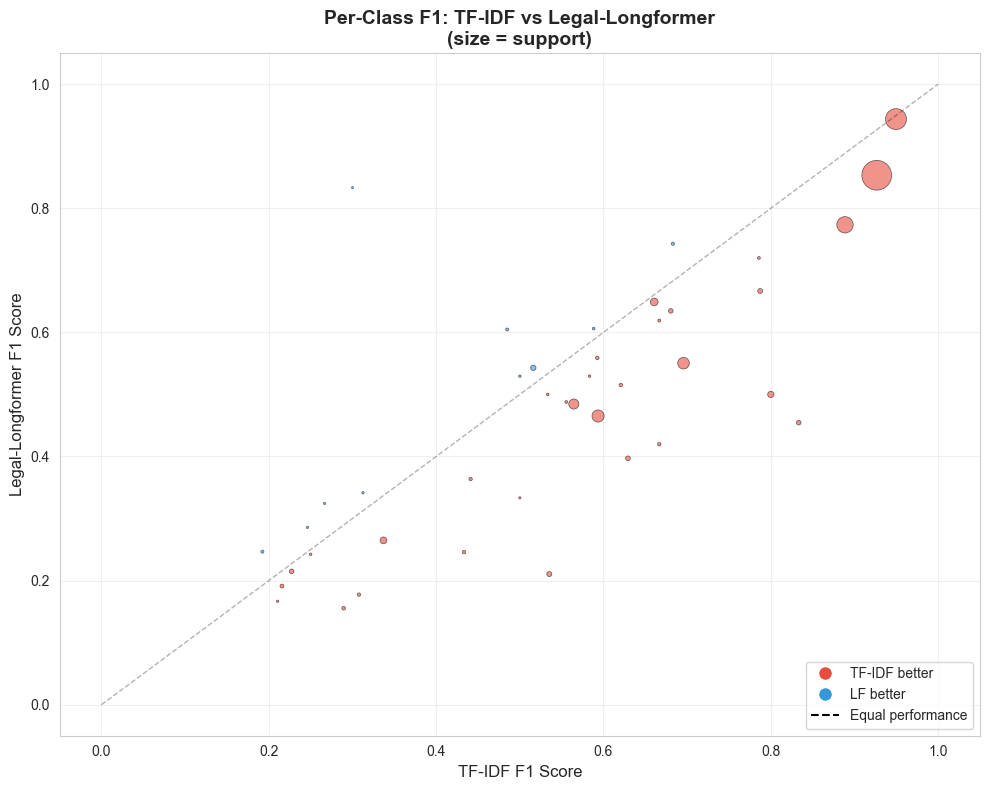

In [12]:
# Scatter: F1 comparison per class
fig, ax = plt.subplots(figsize=(10, 8))

colors = ['#e74c3c' if model == 'TF-IDF' else '#3498db' for model in comparison_df['better_model']]
sizes = comparison_df['support'] / 3

scatter = ax.scatter(comparison_df['f1_tfidf'], comparison_df['f1_lf'], 
           c=colors, s=sizes, alpha=0.6, edgecolors='black', linewidth=0.5)

ax.plot([0, 1], [0, 1], 'k--', alpha=0.3, linewidth=1)

ax.set_xlabel('TF-IDF F1 Score', fontsize=12)
ax.set_ylabel('Legal-Longformer F1 Score', fontsize=12)
ax.set_title('Per-Class F1: TF-IDF vs Legal-Longformer\n(size = support)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#e74c3c', markersize=10, label='TF-IDF better'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#3498db', markersize=10, label='LF better'),
    Line2D([0], [0], color='k', linestyle='--', label='Equal performance')
]
ax.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.show()

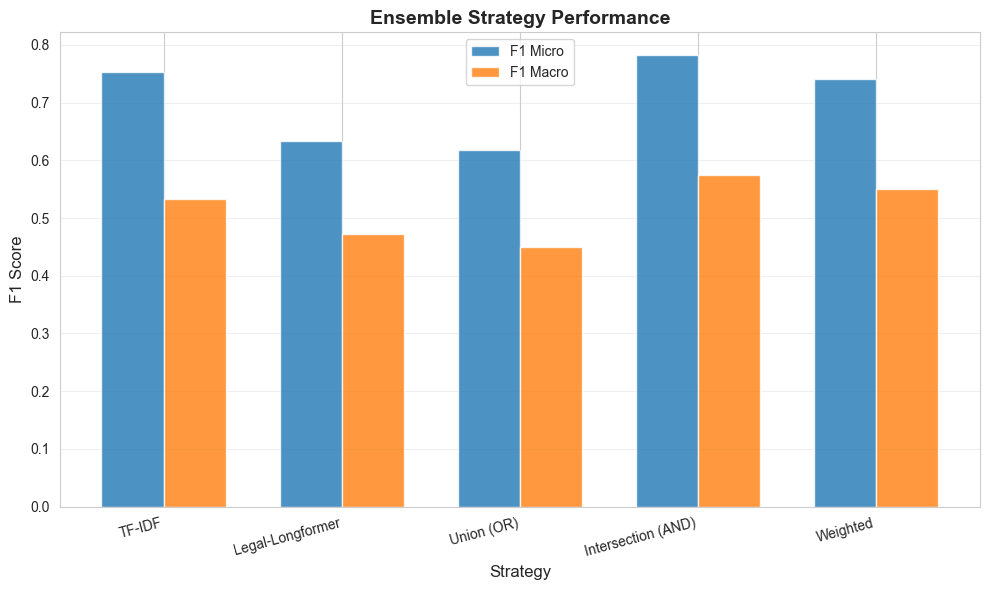

In [13]:
# Bar chart: Strategy comparison
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(results_df))
width = 0.35

ax.bar(x - width/2, results_df['F1 Micro'], width, label='F1 Micro', alpha=0.8)
ax.bar(x + width/2, results_df['F1 Macro'], width, label='F1 Macro', alpha=0.8)

ax.set_xlabel('Strategy', fontsize=12)
ax.set_ylabel('F1 Score', fontsize=12)
ax.set_title('Ensemble Strategy Performance', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(results_df['Strategy'], rotation=15, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 6. Key Findings for Question 3

In [14]:
# Summary statistics
print("=" * 80)
print("KEY FINDINGS: ENSEMBLE POTENTIAL")
print("=" * 80)

print(f"\n1. MODEL COMPLEMENTARITY")
print(f"   Overall agreement: {(both_positive.sum() + both_negative.sum())/total*100:.1f}%")
print(f"   TF-IDF excels on {len(tfidf_better)} classes")
print(f"   Legal-Longformer excels on {len(lf_better)} classes")

print(f"\n2. ENSEMBLE PERFORMANCE")
print(f"   Best strategy: {best_strategy['Strategy']}")
print(f"   F1 Micro: {best_strategy['F1 Micro']:.4f} ({improvement:+.2f}pp vs TF-IDF)")
print(f"   F1 Macro: {best_strategy['F1 Macro']:.4f}")

print(f"\n3. CLASSES NEEDING ATTENTION")
both_struggle = comparison_df[(comparison_df['f1_tfidf'] < 0.5) & (comparison_df['f1_lf'] < 0.5)]
print(f"   {len(both_struggle)} classes with F1 < 0.5 on BOTH models")
print(f"   These need alternative approaches (data augmentation, ontology heuristics)")

print(f"\n4. RECOMMENDATION")
if improvement > 1.0:
    print(f"   Strong ensemble benefit - implement weighted voting strategy")
    print(f"   Expected gain: {improvement:.1f}pp on test set")
elif improvement > 0:
    print(f"   Modest ensemble benefit - consider alongside other improvements")
    print(f"   May be more valuable with threshold tuning")
else:
    print(f"   Simple ensembling insufficient - focus on:")
    print(f"   - Ontology-guided predictions")
    print(f"   - Data augmentation for rare classes")
    print(f"   - Per-model threshold optimization before ensembling")

print("\n" + "=" * 80)

KEY FINDINGS: ENSEMBLE POTENTIAL

1. MODEL COMPLEMENTARITY
   Overall agreement: 96.6%
   TF-IDF excels on 21 classes
   Legal-Longformer excels on 5 classes

2. ENSEMBLE PERFORMANCE
   Best strategy: Intersection (AND)
   F1 Micro: 0.7827 (+3.03pp vs TF-IDF)
   F1 Macro: 0.5752

3. CLASSES NEEDING ATTENTION
   13 classes with F1 < 0.5 on BOTH models
   These need alternative approaches (data augmentation, ontology heuristics)

4. RECOMMENDATION
   Strong ensemble benefit - implement weighted voting strategy
   Expected gain: 3.0pp on test set

